In [1]:
from collections import defaultdict
from IPython.display import clear_output
import os
import sys
import pickle
import random
import requests
import time
import tqdm

from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
from pytorch_ranger import Ranger
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler

sys.path.append("/Users/xuxiaoan/Downloads/recsys-rl-master")
from utils import *
    #(EvalDataset, OUNoise, Prioritized_Buffer, get_beta,
    #               preprocess_data, to_np, hit_metric, dcg_metric)

In [2]:
data_dir = "data"
rating = "ratings.csv"

params = {
    'max_epoch': 15,
    'batch_size': 64,
    'embedding_dim': 8,
    'hidden_dim': 64,
    'N': 5, # memory size for state_repr
    'ou_noise':False,
    'value_lr': 1e-4,
    'value_decay': 1e-4,
    'policy_lr': 1e-4,
    'policy_decay': 1e-6,
    'state_repr_lr': 1e-4,
    'state_repr_decay': 1e-3,
    'log_dir': 'logs/final/',
    'gamma': 0.8,
    'min_value': -10,
    'max_value': 10,
    'soft_tau': 1e-3,
    'buffer_size': 100000
}

## 0. Problem statement

Traditional recommendation task can be treated as sequental desicion making problem.
Recommender (i.e. agent) interacts with users (i.e. environment) to sequentally suggest set of items.
The goal is to maximize clients' satisfaction (i.e. reward).
More specifically:
- State is a vector $a \in R^{3\cdot embedding\_dim}$ computed using the user embedding and the embeddings of `N` latest positive interactions. In the code (replay buffer) state is represented  by `(user, memory)`
- Action is a vector $a \in R^{embedding\_dim}$. To get ranking score we took dot product of
the action and the item embedding (similar to word2vec and other embedding models).
- Reward is taken from user-item matrix (1 if rating > 3, 0 otherwise)

Reinforcement Learning can help recommendation at least in 2 ways.
1. User’s preference on previous items will affect his choice on the next items. 
User tends to give a higher rating if he has consecutively received more satisfied items (and vice versa). 
So, it would be more reasonable to model the recommendation as a sequential decision making process.
2. It is important to use long-term planning in recommendations. For example, after reading the weather forecast, the user is not willing
to read similar news. On the other hand, after watching funny videos or reading memes the user can constanly do the same.

In [3]:
# Movielens (1M) data from the https://github.com/hexiangnan/neural_collaborative_filtering
if not os.path.isdir('./data'):
    os.mkdir('./data')
    
file_path = os.path.join(data_dir, rating)
if os.path.exists(file_path):
    print("Skip loading " + file_path)
else:
    with open(file_path, "wb") as tf:
        print("Load " + file_path)
        r = requests.get("https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/" + rating)
        tf.write(r.content)
        
(train_data, train_matrix, valid_data, valid_matrix, test_data, test_matrix,
 user_num, item_num, appropriate_users, mapping, reverse_mapping) = preprocess_data(data_dir, rating)

Skip loading data/ratings.csv


## 1. Environment

- **Observation space**. As mentioned before, to get state we need `N` latest positive items (`memory`) and embedding of user. `State_Repr_Module` transform it to the vector of dimensionality `embedding_dim * 3`.

- **Action space**. For every user we sample nonrelated items (the same count as related). All `available_items` which wasn't viewed before form action space.

Given a state we get action embedding, compute dot product between this embedding and embeddings of all items in action space, take 1 top ranked item, compute reward, update `viewed_items` and memory, and store transition in buffer.

In [4]:
class Env():
    def __init__(self, user_item_matrix):
        self.matrix = user_item_matrix
        self.item_count = item_num
        self.good_memory = np.ones([user_num, params['N']]) * item_num
        self.bad_memory = np.ones([user_num, params['N']]) * item_num
        # memory is initialized as [item_num] * N for each user
        # it is padding indexes in state_repr and will result in zero embeddings

    # 候选集合为x个有评分的items和x和无评分的items，推荐item个数等同于rating>3的item个数
    def reset(self, user_id):
        self.user_id = user_id
        self.viewed_items = []
        self.related_items = np.argwhere(self.matrix[self.user_id] > 0)[:, 1]
        self.good_items = np.argwhere(self.matrix[self.user_id] > 3)[:, 1]
        self.bad_items = np.intersect1d(np.argwhere(self.matrix[self.user_id]<3)[:,1],
                                        np.argwhere(self.matrix[self.user_id] > 0)[:, 1])
        self.num_rele = len(self.related_items)
        self.num_good = len(self.good_items)
        self.num_bad = len(self.bad_items)

        # 候选推荐集合
        # self.available_items = np.arange(9066)
        self.nonrelated_items = np.random.choice(
            list(set(range(self.item_count)) - set(self.related_items)), self.num_rele)

        self.available_items = np.zeros(self.num_rele*2)
        self.available_items[::2] = self.related_items
        self.available_items[1::2] = self.nonrelated_items

        return torch.tensor([self.user_id]), torch.tensor(self.good_memory[[self.user_id], :]), torch.tensor(self.bad_memory[[self.user_id], :])
    
    def step(self, action, action_emb=None, buffer=None):
        initial_user = self.user_id
        initial_good_memory = self.good_memory[[initial_user], :]
        initial_bad_memory = self.bad_memory[[initial_user], :]

        # 通过rating计算reward（按照原文）
        if to_np(action) not in self.related_items:
            rating = 0
            reward = 0
        else:
            rating = self.matrix[self.user_id, to_np(action)[0]]
            reward = (rating - 3) / 2

        self.viewed_items.append(to_np(action)[0])

        # rating>3才更新状态
        if reward > 0:
            if len(action) == 1:
                self.good_memory[self.user_id] = list(self.good_memory[self.user_id][1:]) + [action]
            else:
                self.good_memory[self.user_id] = list(self.good_memory[self.user_id][1:]) + [action[0]]

        elif reward < 0:
            if len(action) == 1:
                self.bad_memory[self.user_id] = list(self.bad_memory[self.user_id][1:]) + [action]
            else:
                self.bad_memory[self.user_id] = list(self.bad_memory[self.user_id][1:]) + [action[0]]

        # 推荐商品个数 = rating>3的商品个数
        if len(self.viewed_items) == self.num_good:
            done = 1
        else:
            done = 0

        # 向replay buffer存储SARS
        if buffer is not None:
            buffer.push(np.array([initial_user]), np.array(initial_good_memory),
                        np.array(initial_bad_memory), to_np(action_emb)[0],
                        np.array([reward]), np.array([self.user_id]), self.good_memory[[self.user_id], :],
                        self.bad_memory[[self.user_id], :], np.array([done]))

        return torch.tensor([self.user_id]), torch.tensor(self.good_memory[[self.user_id], :]), \
            torch.tensor(self.bad_memory[[self.user_id], :]), reward, rating, done

## 2. Model

### Overall model

<img src="img/full_model.png" width="500" height="350">

In [5]:
class Actor_DRR(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.good_policy_net = nn.Sequential(
            nn.Linear(embedding_dim * 15, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        self.bad_policy_net = nn.Sequential(
            nn.Linear(embedding_dim * 15, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        
        self.initialize()

    def initialize(self):
        for layer in self.good_policy_net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
        for layer in self.bad_policy_net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)

    def forward(self, user, good_memory, bad_memory):
        good_state       = state_repr(user, good_memory)
        bad_state       = state_repr(user, bad_memory)

        good_action_emb = self.good_policy_net(good_state)
        bad_action_emb = self.bad_policy_net(bad_state)

        norm_good_action_emb = good_action_emb / torch.norm(good_action_emb)
        norm_bad_action_emb = bad_action_emb / torch.norm(bad_action_emb)
        return norm_good_action_emb - self.alpha * norm_bad_action_emb

    # 只在available items中选择最接近的item，否则大量reward=0，不利于训练
    def get_action(self, state_repr, action_emb,
                   items=torch.tensor([i for i in range(item_num)]),
                   return_scores=False):

        scores = torch.bmm(state_repr.item_embeddings(items).unsqueeze(0),
                         action_emb.T.unsqueeze(0)).squeeze(0)

        if return_scores:
            return scores, torch.gather(items, 0, scores.argmax(0))
        else:
            return torch.gather(items, 0, scores.argmax(0))

In [6]:
class Critic_DRR(nn.Module):
    def __init__(self, state_repr_dim, action_emb_dim, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_repr_dim + action_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        self.initialize()
        
    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)


    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.layers(x)
        return x

### State representation

<img src="img/state_representation.png" width="350" height="250">

In [7]:
class State_Repr_Module(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        # item需要padding补齐
        self.item_embeddings = nn.Embedding(item_num+1, embedding_dim, padding_idx=int(item_num))
        # self.drr_ave = torch.nn.Conv1d(in_channels=params['N'], out_channels=1, kernel_size=1)
        # self.drr_p1 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        # self.drr_p2 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        # self.drr_p3 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        # self.drr_p4 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        # self.drr_p5 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)

        self.drr_u1 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        self.drr_u2 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        self.drr_u3 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        self.drr_u4 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        self.drr_u5 = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        self.initialize()
            
    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        self.item_embeddings.weight.data[-1].zero_()
        nn.init.kaiming_uniform_(self.drr_u1.weight)
        self.drr_u1.bias.data.zero_()
        nn.init.kaiming_uniform_(self.drr_u2.weight)
        self.drr_u2.bias.data.zero_()
        nn.init.kaiming_uniform_(self.drr_u3.weight)
        self.drr_u3.bias.data.zero_()
        nn.init.kaiming_uniform_(self.drr_u4.weight)
        self.drr_u4.bias.data.zero_()
        nn.init.kaiming_uniform_(self.drr_u5.weight)
        self.drr_u5.bias.data.zero_()
        # nn.init.uniform_(self.drr_ave.weight)
        # self.drr_ave.bias.data.zero_()

    def forward(self, user, memory):
        user_embedding = self.user_embeddings(user.long())
        item_embeddings = self.item_embeddings(memory.long())
        # drr_p1 = self.drr_p1(item_embeddings[:,0,:].unsqueeze(1)).squeeze(1)
        # drr_p2 = self.drr_p2(item_embeddings[:,1,:].unsqueeze(1)).squeeze(1)
        # drr_p3 = self.drr_p3(item_embeddings[:,2,:].unsqueeze(1)).squeeze(1)
        # drr_p4 = self.drr_p4(item_embeddings[:,3,:].unsqueeze(1)).squeeze(1)
        # drr_p5 = self.drr_p5(item_embeddings[:,4,:].unsqueeze(1)).squeeze(1)
        # drr_p = [drr_p1, drr_p2, drr_p3, drr_p4, drr_p5]
        # temp = torch.cat(tuple(drr_p[i] * drr_p[j] for i in range(5) for j in range(i,5) if i !=j), 1)
        # return torch.cat((item_embeddings.reshape(item_embeddings.shape[0],-1), temp), 1)

        drr_u1 = self.drr_u1(item_embeddings[:,0,:].unsqueeze(1)).squeeze(1)
        drr_u2 = self.drr_u2(item_embeddings[:,1,:].unsqueeze(1)).squeeze(1)
        drr_u3 = self.drr_u3(item_embeddings[:,2,:].unsqueeze(1)).squeeze(1)
        drr_u4 = self.drr_u4(item_embeddings[:,3,:].unsqueeze(1)).squeeze(1)
        drr_u5 = self.drr_u5(item_embeddings[:,4,:].unsqueeze(1)).squeeze(1)
        drr_u = [drr_u1, drr_u2, drr_u3, drr_u4, drr_u5]
        temp2 = torch.cat(tuple(drr_u[i] * drr_u[j] for i in range(5) for j in range(i,5) if i !=j), 1)
        temp1 = torch.cat(tuple(user_embedding * i for i in drr_u), 1)
        return torch.cat((temp1, temp2), 1)

        # drr_ave = self.drr_ave(item_embeddings).squeeze(1)
        # return torch.cat((user_embedding, user_embedding * drr_ave, drr_ave), 1)

For evaluation we take 1 positive and 99 sampled negatives items per batch, select 10 items with best scores and calculate hit_rate@10 and nDCG@10.
During training we choose user 6039 and track `hit` and `dcg` only for him (for evaluation speed). Final scores was computed on the whole test data.

In [8]:
# load pre-trained memory
with open('logs/memory.pickle', 'rb') as f:
    test_memory = pickle.load(f)

In [9]:
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0

def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0
    return dcg_at_k(r, k) / dcg_max

In [10]:
def count_greater_than_x(list, x):
    count = 0
    for element in list:
        if element > x:
            count += 1
    return count

In [11]:
def run_evaluation(matrix, net, state_representation, training_env_memory=test_memory):
    test_env = Env(matrix)
    test_env.memory = training_env_memory.copy()
    ndcg_at_5_list = []
    precision_at_5_list = []
    for user in range(user_num):
        user, good_memory, bad_memory = test_env.reset(user)
        if test_env.num_rele < 5:
            continue
        else:
            rating_list = []
            for t in range(5):
                action_emb = net(user, good_memory, bad_memory)

                scores, action = net.get_action(
                    state_representation, action_emb,
                    torch.tensor([item for item in test_env.related_items
                    if item not in test_env.viewed_items]).long(),
                    return_scores=True
                )
                user, good_memory, bad_memory, reward, rating, done = test_env.step(action)
                rating_list.append(rating)
            ndcg_at_5 = ndcg_at_k(rating_list,5)
            ndcg_at_5_list.append(ndcg_at_5)
            precision_at_5_list.append(count_greater_than_x(rating_list,3)/5)
    return np.mean(precision_at_5_list), np.mean(ndcg_at_5_list)

## 3. Training

In [12]:
torch.manual_seed(1)

state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
actor_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
critic_net  = Critic_DRR(params['embedding_dim'] * 15, params['embedding_dim'], params['hidden_dim'])
replay_buffer = Prioritized_Buffer(params['buffer_size'])


target_critic_net  = Critic_DRR(params['embedding_dim'] * 15, params['embedding_dim'], params['hidden_dim'])
target_actor_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])

for target_param, param in zip(target_critic_net.parameters(), critic_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_actor_net.parameters(), actor_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion  = nn.MSELoss()
critic_optimizer  = Ranger(critic_net.parameters(),  lr=params['value_lr'],
                          weight_decay=params['value_decay'])
actor_optimizer = Ranger(actor_net.parameters(), lr=params['policy_lr'],
                          weight_decay=params['policy_decay'])
state_repr_optimizer = Ranger(state_repr.parameters(), lr=params['state_repr_lr'],
                              weight_decay=params['state_repr_decay'])

critic_scheduler = lr_scheduler.ExponentialLR(critic_optimizer, gamma=0.8)
actor_scheduler = lr_scheduler.ExponentialLR(actor_optimizer, gamma=0.8)
state_repr_scheduler = lr_scheduler.ExponentialLR(state_repr_optimizer, gamma=0.8)

# writer = SummaryWriter(log_dir=params['log_dir'])

loss = {
    'test': {'precision': [], 'ndcg': [], 'step': []},
    'train': {'value': [], 'policy': [], 'step': []}
    }
plotter = Plotter(loss, [['value', 'policy'],['precision','ndcg']])

In [13]:
def ddpg_update(training_env,
                step=0,
                batch_size=params['batch_size'], 
                gamma=params['gamma'],
                min_value=params['min_value'],
                max_value=params['max_value'],
                soft_tau=params['soft_tau'],
               ):
    beta = get_beta(step)
    user, good_memory, bad_memory, action, reward, next_user, next_good_memory, next_bad_memory, done = replay_buffer.sample(batch_size, beta)
    user        = torch.FloatTensor(user)
    good_memory      = torch.FloatTensor(good_memory)
    bad_memory      = torch.FloatTensor(bad_memory)
    action      = torch.FloatTensor(action)
    reward      = torch.FloatTensor(reward)
    next_user   = torch.FloatTensor(next_user)
    next_good_memory = torch.FloatTensor(next_good_memory)
    next_bad_memory = torch.FloatTensor(next_bad_memory)
    done = torch.FloatTensor(done)

    # 计算策略损失(更新policy_net和state_repr和action_net)
    good_state = state_repr(user, good_memory)
    action_emb = actor_net(user, good_memory, bad_memory)

    policy_loss = critic_net(good_state,action_emb)
    policy_loss = -policy_loss.mean()

    # 计算价值损失(更新value_net和state_repr)
    next_good_state = state_repr(next_user, next_good_memory)
    next_action_emb = target_actor_net(next_user, next_good_memory, next_bad_memory)

    target_value   = target_critic_net(next_good_state, next_action_emb.detach())

    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = critic_net(good_state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    state_repr_optimizer.zero_grad()
    actor_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    actor_optimizer.step()

    critic_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    critic_optimizer.step()
    state_repr_optimizer.step()

    for target_param, param in zip(target_critic_net.parameters(), critic_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )

    for target_param, param in zip(target_actor_net.parameters(), actor_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    # 动态更新训练loss
    losses = {"value": value_loss.item(), "policy": policy_loss.item(), "step": step}
    plotter.log_losses(losses)

    # writer.add_histogram('value', value, step)
    # writer.add_histogram('target_value', target_value, step)
    # writer.add_histogram('expected_value', expected_value, step)
    # writer.add_histogram('policy_loss', policy_loss, step)
    # writer.add_histogram('value_loss', value_loss, step)

In [14]:
np.random.seed(15)
train_env = Env(train_matrix)
precisions, ndcgs = [], []
step, best_step = 0, 0
users = np.random.permutation(appropriate_users)
ou_noise = OUNoise(params['embedding_dim'], decay_period=10)

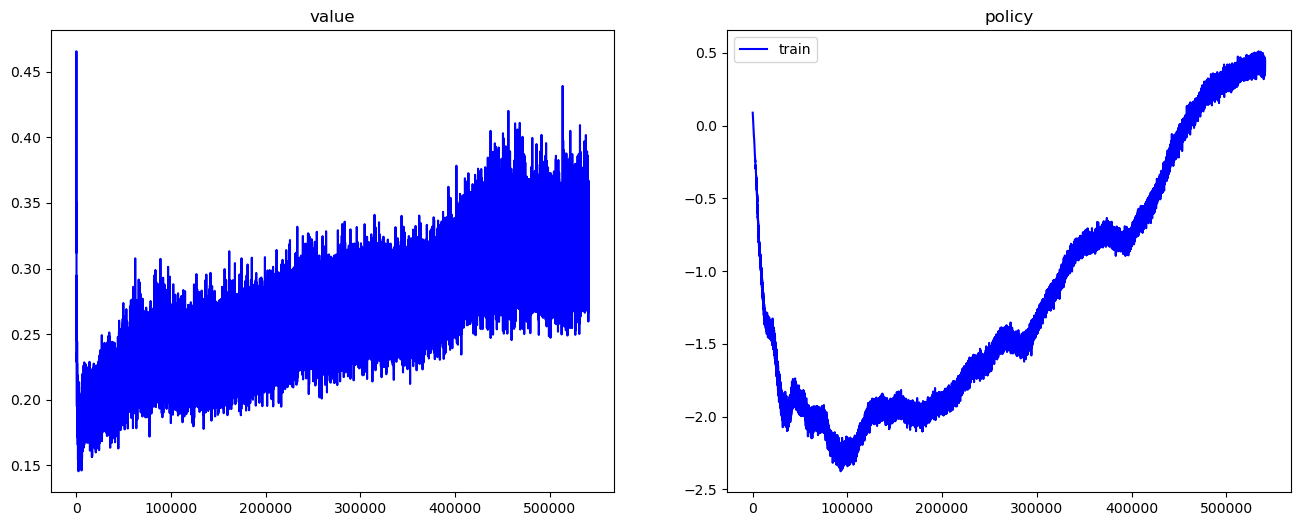

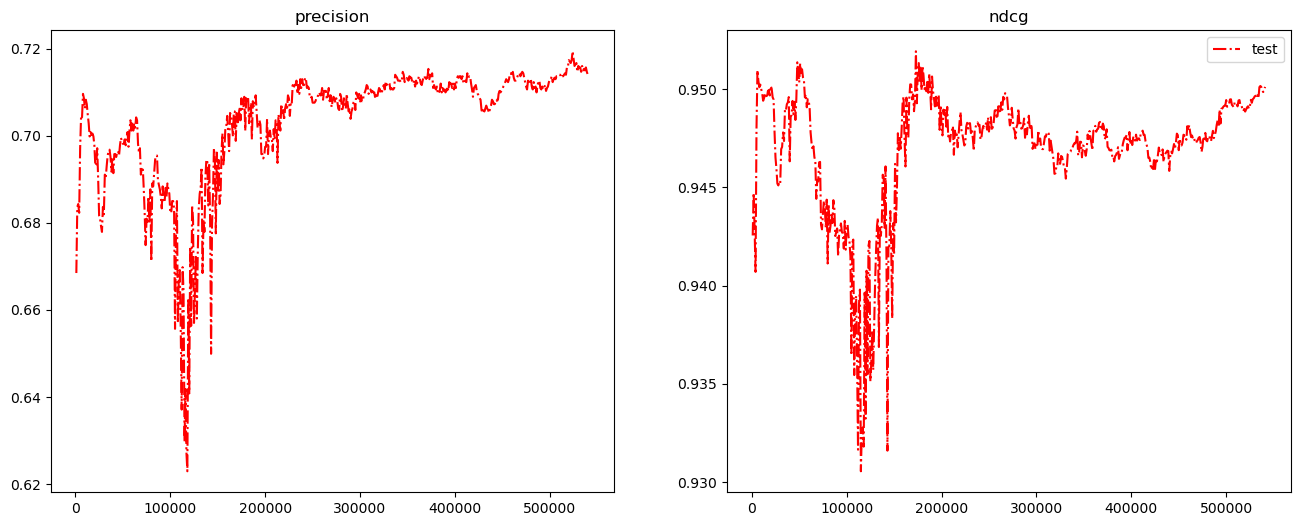

100%|██████████| 534/534 [24:07<00:00,  2.71s/it]


In [15]:
for epoch in range(params["max_epoch"]):
    for u in tqdm.tqdm(users):
        user, good_memory, bad_memory = train_env.reset(u)
        if params['ou_noise']:
            ou_noise.reset()
        for t in range(train_env.num_good):
            action_emb = actor_net(user, good_memory, bad_memory)

            if params['ou_noise']:
                action_emb = ou_noise.get_action(action_emb.detach().cpu().numpy()[0], t)
            action = actor_net.get_action(
                state_repr, action_emb,
                torch.tensor(
                    [item for item in train_env.available_items
                    if item not in train_env.viewed_items]
                ).long()
            )

            # 返回S'R，并将transition传入replay buffer
            user, good_memory, bad_memory, reward, rating, done = train_env.step(
                action,
                action_emb,
                buffer=replay_buffer
            )

            if len(replay_buffer) > params['batch_size']:
                ddpg_update(train_env, step=step)

            # 每1000个step保存最优参数（使得ndcg@10最大）（使用同一个test_memory）
            if step % 1000 == 0 and step > 0:
                precision, ndcg = run_evaluation(valid_matrix, actor_net, state_repr, test_memory)
                losses = {"precision": precision.item(), "ndcg": ndcg.item(), "step": step}
                plotter.log_losses(losses, test=True)
                clear_output()
                plotter.plot_loss()
                # writer.add_scalar('precision', precision, step)
                # writer.add_scalar('ndcg', ndcg, step)
                precisions.append(precision)
                ndcgs.append(ndcg)
                # print(precision,ndcg)
                if np.mean(np.array([ndcg]) - np.array(ndcgs[best_step])) > 0:
                    # best_step是当前step在ndcgs中的index，ndcgs的元素为从1000开始
                    best_step = step // 1000 - 1
                    torch.save(actor_net.state_dict(), params['log_dir'] + 'best_policy_net.pth')
                    torch.save(critic_net.state_dict(), params['log_dir'] + 'best_value_net.pth')
                    torch.save(state_repr.state_dict(), params['log_dir'] + 'best_state_repr.pth')
            step += 1

    critic_scheduler.step()
    actor_scheduler.step()
    state_repr_scheduler.step()

In [ ]:
torch.save(policy_net.state_dict(), params['log_dir'] + 'policy_net_final.pth')
torch.save(value_net.state_dict(), params['log_dir'] + 'value_net_final.pth')
torch.save(state_repr.state_dict(), params['log_dir'] + 'state_repr_final.pth')

In [16]:
# we need memory for validation, so it's better to save it and not wait next time 
with open('logs/memory.pickle', 'wb') as f:
    pickle.dump(train_env.memory, f)
    
with open('logs/memory.pickle', 'rb') as f:
    memory = pickle.load(f)

## 4. Results

Weights and logs are stored in [this folder](https://drive.google.com/drive/folders/1hsGjh8oHN4uyCmp_wtAyVPTR76ylVVgH?usp=sharing)

In [16]:
no_ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
no_ou_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
no_ou_state_repr.load_state_dict(torch.load('logs/final/' + 'best_state_repr.pth'))
no_ou_policy_net.load_state_dict(torch.load('logs/final/' + 'best_policy_net.pth'))


hit, dcg = run_evaluation(test_matrix, no_ou_policy_net, no_ou_state_repr, test_memory)
print('hit rate: ', hit, 'dcg: ', dcg)
# valid_matrix: 0.729245283018868, 0.945637300979402
# test_matrix: 0.7246543778801844, 0.9468706373522575

/var/folders/0w/5fjhh0vx7rbg6mmk_ld1nfvr0000gn/T/ipykernel_39626/201945197.py:51: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  self.good_memory[self.user_id] = list(self.good_memory[self.user_id][1:]) + [action]
/var/folders/0w/5fjhh0vx7rbg6mmk_ld1nfvr0000gn/T/ipykernel_39626/201945197.py:57: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  self.bad_memory[self.user_id] = list(self.bad_memory[self.user_id][1:]) + [action]


hit rate:  0.7023809523809523 dcg:  0.9419407407821367


In [20]:
pickle.dump(loss,open("loss.pickle","wb"))

OrderedDict([('user_embeddings.weight',
              tensor([[ 0.0023, -0.0108,  0.0158,  ..., -0.0080, -0.0040,  0.0190],
                      [-0.5677, -0.2398, -0.3151,  ..., -0.5659,  0.1755,  0.5294],
                      [-0.4726, -0.2204, -0.3469,  ..., -0.4684,  0.2811,  0.4177],
                      ...,
                      [-0.4951, -0.0199, -0.3772,  ..., -0.3700,  0.1176,  0.4185],
                      [-0.4769, -0.1378, -0.3044,  ..., -0.5171,  0.1876,  0.4732],
                      [-0.8625, -0.2525, -0.5835,  ..., -0.3851,  0.3290,  0.7877]])),
             ('item_embeddings.weight',
              tensor([[-0.0008, -0.0308, -0.0225,  ..., -0.0162,  0.0819,  0.0490],
                      [ 0.0024, -0.0252, -0.0219,  ..., -0.0408,  0.0950,  0.0737],
                      [-0.0175, -0.0141, -0.0117,  ..., -0.0087,  0.0161,  0.0595],
                      ...,
                      [ 0.0062, -0.0044, -0.0079,  ...,  0.0173,  0.0105, -0.0150],
                      [

In [17]:
ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
ou_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
ou_state_repr.load_state_dict(torch.load('logs/ou_noise_04/' + 'best_state_repr.pth'))
ou_policy_net.load_state_dict(torch.load('logs/ou_noise_04/' + 'best_policy_net.pth'))

hit, dcg = run_evaluation(ou_policy_net, ou_state_repr, test_memory)
print('hit rate: ', hit, 'dcg: ', dcg)

/var/folders/0w/5fjhh0vx7rbg6mmk_ld1nfvr0000gn/T/ipykernel_33216/4137504441.py:33: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action]


hit rate:  0.502304510193194 dcg:  0.2798106994373345


### Example of trained agents behaviour

Let's choose random user

In [19]:
random_user = np.random.randint(user_num)
print(random_user)

5983


In [23]:
movies = pd.read_csv('/Users/xuxiaoan/Downloads/recsys-rl-master/data/movies.dat', sep='::', header=None, engine='python', names=['id', 'name', 'genre'], encoding="latin-1")
# in the code numeration starts with 0
display(movies[movies['id'].isin(np.argwhere(test_matrix[random_user] > 0)[:, 1] + 1)])

,id,name,genre
44,45,To Die For (1995),Comedy|Drama
64,65,Bio-Dome (1996),Comedy
131,133,Nueba Yol (1995),Comedy|Drama
639,644,Happy Weekend (1996),Comedy
706,715,"Horseman on the Roof, The (Hussard sur le toit...",Drama
979,991,Michael Collins (1996),Drama|War
989,1002,Ed's Next Move (1996),Comedy
1222,1242,Glory (1989),Action|Drama|War


For example we can recommend "Nixon" and "Love Serenade" and see next 3 predictions.

In [26]:
predictions = []

for model, state_representation in zip([ou_policy_net, no_ou_policy_net], [ou_state_repr, no_ou_state_repr]):
    example_env = Env(test_matrix)
    user, memory = example_env.reset(random_user)

    user, memory, reward, _ = example_env.step(torch.tensor([44])) # 13
    user, memory, reward, _ = example_env.step(torch.tensor([1001])) # 1584
    preds = []
    for _ in range(3):
        action_emb = model(state_representation(user, memory))
        action = model.get_action(
            user, 
            torch.tensor(example_env.memory[to_np(user).astype(int), :]), 
            state_representation, 
            action_emb,
            torch.tensor(
               [item for item in example_env.available_items
               if item not in example_env.viewed_items]
            ).long()
        )
        user, memory, reward, _ = example_env.step(action)
        preds.append(action)

    predictions.append(preds)

print(predictions[0])
print(predictions[1])

[tensor([132]), tensor([714]), tensor([64])]
[tensor([132]), tensor([64]), tensor([714])]


/var/folders/0w/5fjhh0vx7rbg6mmk_ld1nfvr0000gn/T/ipykernel_33216/4137504441.py:33: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [action]


Model trained with OU noise recommended related `Comedy` and `Documentary` after that switch recommendations to nonrelated `Crime|Film-Noir|Thriller`.
Model trained without OU noise recommended `Comedy|Drama`, `Children's|Comedy`, `Drama` (two of them are related).

Both models seems to be reasonable.

### Training process logs

<img src=img/learning_curve.png>

Logs are consistent with expectations. Adding noise increase metrics (std=0.4 performs the best, after 0.6 model starts to degrade).